# LSTM + AE



# [1] 쉬운 예제

## 1.환경준비

### 1) 라이브러리 로딩

In [ ]:
# import packages
import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

import tensorflow.keras as keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.backend import clear_session

### 2) 데이터셋

In [ ]:
# 간단한 데이터 생성
x = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()
y = np.zeros(9)

timesteps = x.shape[0]
n_features = x.shape[1]
x

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

### 3) 필요 함수들 생성

* 시계열 데이터 분석을 위한 전처리(for LSTM, CNN)

In [ ]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1 ):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

## 2.데이터 준비

In [ ]:
x

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

In [ ]:
timesteps = 3
x1, y1 = temporalize(x, y, timesteps)

In [ ]:
x1.shape, y1.shape

((7, 3, 2), (7,))

In [ ]:
x1

array([[[0.1  , 0.001],
        [0.2  , 0.008],
        [0.3  , 0.027]],

       [[0.2  , 0.008],
        [0.3  , 0.027],
        [0.4  , 0.064]],

       [[0.3  , 0.027],
        [0.4  , 0.064],
        [0.5  , 0.125]],

       [[0.4  , 0.064],
        [0.5  , 0.125],
        [0.6  , 0.216]],

       [[0.5  , 0.125],
        [0.6  , 0.216],
        [0.7  , 0.343]],

       [[0.6  , 0.216],
        [0.7  , 0.343],
        [0.8  , 0.512]],

       [[0.7  , 0.343],
        [0.8  , 0.512],
        [0.9  , 0.729]]])

## 3.모델링 : LSTM+AE



In [ ]:
x1.shape

(7, 3, 2)

In [ ]:
n_features =  x1.shape[2] # 2

In [ ]:
clear_session()

# Encoder
input_layer = Input(shape=(timesteps, n_features))
encoder = LSTM(128, return_sequences=True)(input_layer)
encoder = LSTM(64, return_sequences=False)(encoder)
encoder = RepeatVector(timesteps)(encoder)
# Decoder
decoder = LSTM(64, return_sequences=True)(encoder)
decoder = LSTM(128, return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(n_features))(decoder)
lstm_ae = Model(inputs=input_layer, outputs=decoder)

lstm_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 64)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            98816     
                                                             

In [ ]:
lstm_ae.compile(optimizer='adam', loss = 'mse')
lstm_ae.fit(x1, x1, epochs=50, batch_size=5, verbose=0)

pred = lstm_ae.predict(x1)
print('---Predicted---')
print(np.round(pred,3))
print('---Actual---')
print(np.round(x1, 3))

1/1 [==============================] - 3s 3s/step
---Predicted---
[[[ 0.178  0.009]
  [ 0.261 -0.   ]
  [ 0.3   -0.015]]

 [[ 0.222  0.027]
  [ 0.334  0.036]
  [ 0.382  0.036]]

 [[ 0.278  0.052]
  [ 0.421  0.085]
  [ 0.472  0.103]]

 [[ 0.352  0.087]
  [ 0.525  0.152]
  [ 0.571  0.196]]

 [[ 0.45   0.137]
  [ 0.646  0.247]
  [ 0.67   0.324]]

 [[ 0.577  0.208]
  [ 0.775  0.376]
  [ 0.76   0.491]]

 [[ 0.731  0.306]
  [ 0.897  0.539]
  [ 0.83   0.695]]]
---Actual---
[[[0.1   0.001]
  [0.2   0.008]
  [0.3   0.027]]

 [[0.2   0.008]
  [0.3   0.027]
  [0.4   0.064]]

 [[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


# [2] pulp-and-paper mill 공정 데이터

## 1.환경준비

### 1) 라이브러리 로딩

In [ ]:
# import packages
import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

import tensorflow.keras as keras
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.backend import clear_session

### 2) 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [ ]:
def recon_err_plot(x, x_pred, y, threshold=0):
    mse = np.mean(np.power(x_val_s.reshape(x.shape[0], -1) - x_pred.reshape(x_pred.shape[0], -1), 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Break" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다.
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return confusion_matrix(y, pred_temp)

#### ④ DL 학습곡선 그리기


In [ ]:
def plot_learning_curve(history) :
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

#### ⑤ 시계열 데이터 분석을 위한 전처리(for LSTM, CNN)

In [ ]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

#### ⑥ 스케일링을 위한 함수
* LSTM+AE를 위한 데이터를 표준화하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : temporalize를 원래대로 돌려 놓는 함수
    * scale : 3D 배열의 데이터에 스케일링 적용(transform)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

### 3) 데이터셋 불러오기

In [ ]:
# 공정 데이터 불러오기
path = "processminer2.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


## 2.데이터 준비

### 1) 불필요한 변수 제거

불필요한 변수 제거 : time

In [ ]:
data.drop('time', axis=1, inplace=True)

In [ ]:
data.shape

(18274, 60)

### 2) 시계열 분석을 위한 데이터 만들기

* x, y 분리

In [ ]:
target = 'y'
input_x = data.drop(target, axis = 1).values
input_y = data['y'].values

In [ ]:
input_x.shape

(18274, 59)

* timestep에 맞게 data point를 2차원으로 변환  
(data point : 2차원 ==> data set : 3차원)

In [ ]:
timestep = 10
x, y = temporalize(input_x, input_y, timestep)

In [ ]:
x.shape, y.shape

((18265, 10, 59), (18265,))

In [ ]:
data.iloc[:12, :5]

,y,x1,x2,x3,x4
0,0.0,0.376665,-4.596435,-4.095756,13.497687
1,0.0,0.475720,-4.542502,-4.018359,16.230659
2,0.0,0.363848,-4.681394,-4.353147,14.127997
3,0.0,0.301590,-4.758934,-4.023612,13.161566
4,0.0,0.265578,-4.749928,-4.333150,15.267340
5,0.0,0.381253,-4.611746,-4.085072,14.143195
6,0.0,0.313325,-4.530210,-4.120931,18.681465
7,0.0,0.396401,-4.699047,-4.074193,21.307655
8,0.0,0.342688,-4.553506,-4.188885,22.892035
9,0.0,0.458252,-4.639561,-4.246547,23.160957


In [ ]:
pd.DataFrame(x[0, :, :4])

,0,1,2,3
0,0.376665,-4.596435,-4.095756,13.497687
1,0.475720,-4.542502,-4.018359,16.230659
2,0.363848,-4.681394,-4.353147,14.127997
3,0.301590,-4.758934,-4.023612,13.161566
4,0.265578,-4.749928,-4.333150,15.267340
5,0.381253,-4.611746,-4.085072,14.143195
6,0.313325,-4.530210,-4.120931,18.681465
7,0.396401,-4.699047,-4.074193,21.307655
8,0.342688,-4.553506,-4.188885,22.892035
9,0.458252,-4.639561,-4.246547,23.160957


In [ ]:
pd.DataFrame(x[1, :, :4])

,0,1,2,3
0,0.475720,-4.542502,-4.018359,16.230659
1,0.363848,-4.681394,-4.353147,14.127997
2,0.301590,-4.758934,-4.023612,13.161566
3,0.265578,-4.749928,-4.333150,15.267340
4,0.381253,-4.611746,-4.085072,14.143195
5,0.313325,-4.530210,-4.120931,18.681465
6,0.396401,-4.699047,-4.074193,21.307655
7,0.342688,-4.553506,-4.188885,22.892035
8,0.458252,-4.639561,-4.246547,23.160957
9,0.393756,-4.811998,-4.116455,27.550849


* 데이터셋 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=6000, random_state=2022)

* Normal 분리 : Normal 데이터로만 학습하기 위해서

In [ ]:
x_train0 = x_train[y_train==0]

### 3) 스케일링 : Standardization

* 학습은 x_train_0을 사용하므로,
* 스케일링도 x_train_0 기준으로 수행


In [ ]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(x_train0))
x_train0_s = scale(x_train0, scaler)

In [ ]:
x_val_s = scale(x_val, scaler)

## 3.모델링



### 1) LSTM + AE ①
* 다음과 같이 구조를 정의하시오.
    * lstm(64)
    * lstm(32)
    * RepeatVector(  )
    * lstm(32)
    * lstm(64)
    * TimeDistributed(Dense(  ))

* 모델이름 : lstm_ae0



In [ ]:
n_features =  x_train0_s.shape[2]

In [ ]:
clear_session()

# Encoder
input_layer = Input(shape=(timestep, n_features))
encoder = LSTM(64, return_sequences=True)(input_layer)
encoder = LSTM(32, return_sequences=False)(encoder)
encoder = RepeatVector(timestep)(encoder)
# Decoder
decoder = LSTM(32, return_sequences=True)(encoder)
decoder = LSTM(64, return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(n_features))(decoder)
lstm_ae0 = Model(inputs=input_layer, outputs=decoder)

lstm_ae0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 59)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            31744     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 32)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            24832     
                                                             

* 학습
    * epochs : 50

In [ ]:
lstm_ae0.compile(optimizer='adam', loss = 'mse')
history = lstm_ae0.fit(x = x_train0_s, y = x_train0_s, epochs=50, batch_size=64
                      , validation_split = 0.2).history

Epoch 1/50
152/152 [==============================] - 11s 23ms/step - loss: 0.6577 - val_loss: 0.4597
Epoch 2/50
152/152 [==============================] - 2s 12ms/step - loss: 0.3906 - val_loss: 0.3547
Epoch 3/50
152/152 [==============================] - 2s 10ms/step - loss: 0.3227 - val_loss: 0.3038
Epoch 4/50
152/152 [==============================] - 2s 11ms/step - loss: 0.2797 - val_loss: 0.2740
Epoch 5/50
152/152 [==============================] - 2s 10ms/step - loss: 0.2553 - val_loss: 0.2523
Epoch 6/50
152/152 [==============================] - 2s 11ms/step - loss: 0.2367 - val_loss: 0.2401
Epoch 7/50
152/152 [==============================] - 2s 14ms/step - loss: 0.2229 - val_loss: 0.2255
Epoch 8/50
152/152 [==============================] - 2s 14ms/step - loss: 0.2120 - val_loss: 0.2189
Epoch 9/50
152/152 [==============================] - 2s 11ms/step - loss: 0.2060 - val_loss: 0.2106
Epoch 10/50
152/152 [==============================] - 2s 10ms/step - loss: 0.1982 - val_l

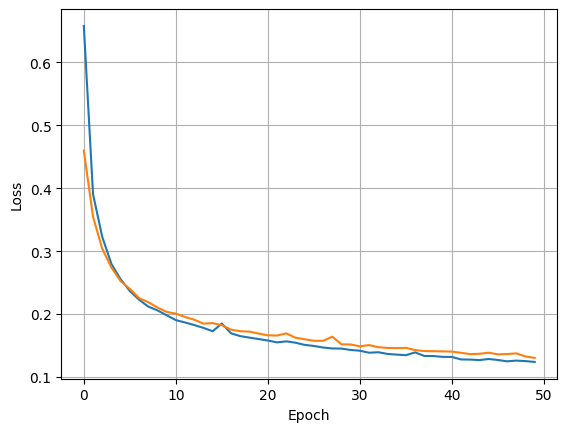

In [ ]:
plot_learning_curve(history)

### 2) LSTM + AE ②
* RepeatVector 제외 모델
* 1번과 동일한 구조로 모델링을 수행하되, RepeatVector를 제외하고 수행합니다.
* RepeatVector를 제외하게 되면 바로 전 LSTM 층에서, return_sequences = True 이어야 합니다.
* 모델이름 : lstm_ae


In [ ]:
clear_session()

# Encoder
input_layer = Input(shape=(timestep, n_features))
encoder = LSTM(64, return_sequences=True)(input_layer)
encoder = LSTM(32, return_sequences=True)(encoder)
# Decoder
decoder = LSTM(32, return_sequences=True)(encoder)
decoder = LSTM(64, return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(n_features))(decoder)
lstm_ae = Model(inputs=input_layer, outputs=decoder)

lstm_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 59)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            31744     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            24832     
                                                                 
 time_distributed (TimeDist  (None, 10, 59)            3835      
 ributed)                                                        
                                                             

* 학습
    * epochs : 50~100

In [ ]:
lstm_ae.compile(optimizer='adam', loss = 'mse')
history = lstm_ae.fit(x = x_train0_s, y = x_train0_s, epochs=50, batch_size=64
                      , validation_split = 0.2).history

Epoch 1/50
152/152 [==============================] - 10s 19ms/step - loss: 0.7269 - val_loss: 0.5300
Epoch 2/50
152/152 [==============================] - 2s 10ms/step - loss: 0.4511 - val_loss: 0.4003
Epoch 3/50
152/152 [==============================] - 2s 12ms/step - loss: 0.3583 - val_loss: 0.3383
Epoch 4/50
152/152 [==============================] - 2s 14ms/step - loss: 0.3077 - val_loss: 0.2989
Epoch 5/50
152/152 [==============================] - 2s 11ms/step - loss: 0.2751 - val_loss: 0.2697
Epoch 6/50
152/152 [==============================] - 2s 10ms/step - loss: 0.2491 - val_loss: 0.2478
Epoch 7/50
152/152 [==============================] - 2s 10ms/step - loss: 0.2284 - val_loss: 0.2279
Epoch 8/50
152/152 [==============================] - 2s 12ms/step - loss: 0.2113 - val_loss: 0.2122
Epoch 9/50
152/152 [==============================] - 2s 10ms/step - loss: 0.1970 - val_loss: 0.1991
Epoch 10/50
152/152 [==============================] - 2s 10ms/step - loss: 0.1856 - val_l

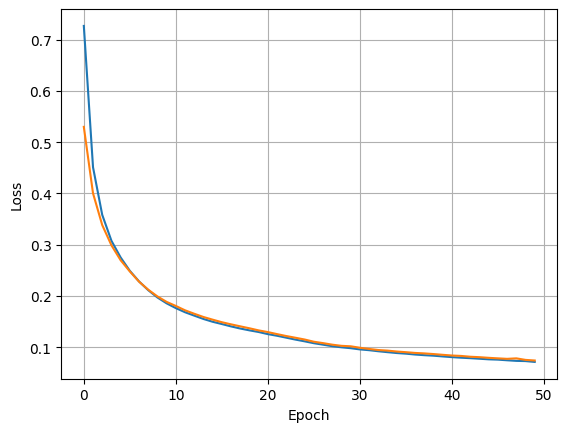

In [ ]:
plot_learning_curve(history)

### 3) 분류에 대한 평가

#### LSTM+AE ①

* val 셋으로 예측하고 reconstruction error로 평가해 봅시다.

In [ ]:
pred0 = lstm_ae0.predict(x_val_s)

188/188 [==============================] - 2s 4ms/step


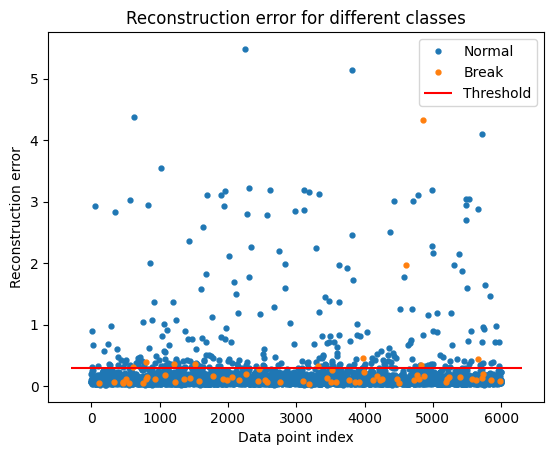

In [ ]:
result0 = recon_err_plot(x_val_s, pred0, y_val, 0.3)

* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

<ipython-input-14-a823bf1fd488>:6: RuntimeWarning: divide by zero encountered in divide
  f1 = 2 / (1/precision + 1/recall)


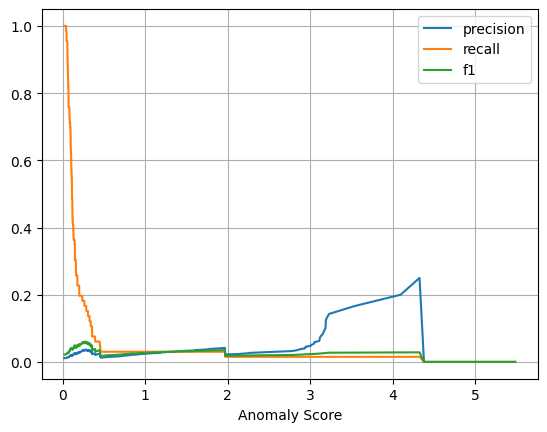

In [ ]:
_, _, f1_0, thresholds = prec_rec_f1_curve(result0['True_class'], result0['Reconstruction_error'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [ ]:
thres_f1_max = thresholds[np.argmax(f1_0)]
thres_f1_max

0.26301919256065065

In [ ]:
cm0 = classification_report2(result0['True_class'], result0['Reconstruction_error'], thres_f1_max)

< confusion matrix >

[[5614  320]
 [  55   11]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      5934
         1.0       0.03      0.17      0.06        66

    accuracy                           0.94      6000
   macro avg       0.51      0.56      0.51      6000
weighted avg       0.98      0.94      0.96      6000



#### LSTM + AE ②

In [ ]:
pred1 = lstm_ae.predict(x_val_s)

188/188 [==============================] - 2s 4ms/step


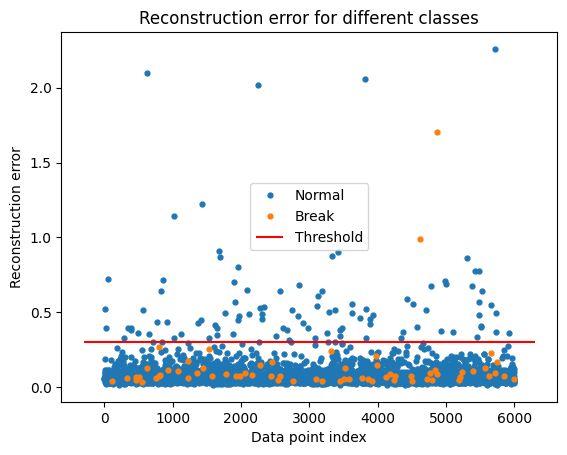

In [ ]:
result1 = recon_err_plot(x_val_s, pred1, y_val, 0.3)

* thresholds 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

<ipython-input-14-a823bf1fd488>:6: RuntimeWarning: divide by zero encountered in divide
  f1 = 2 / (1/precision + 1/recall)


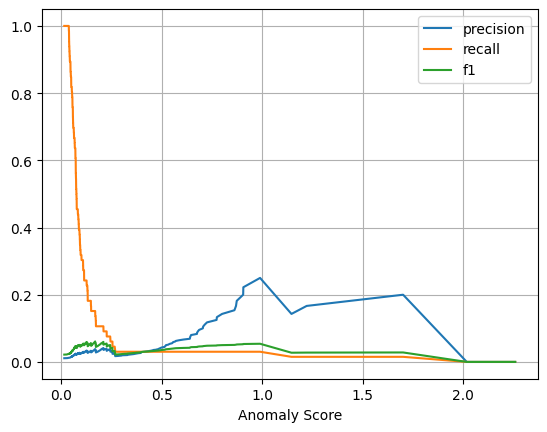

In [ ]:
_, _, f1_1, thresholds = prec_rec_f1_curve(result1['True_class'], result1['Reconstruction_error'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [ ]:
thres_f1_max = thresholds[np.argmax(f1_1)]
thres_f1_max

0.16921583928398315

In [ ]:
cm1 = classification_report2(result1['True_class'], result1['Reconstruction_error'], thres_f1_max)

< confusion matrix >

[[5682  252]
 [  57    9]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      5934
         1.0       0.03      0.14      0.06        66

    accuracy                           0.95      6000
   macro avg       0.51      0.55      0.51      6000
weighted avg       0.98      0.95      0.96      6000



## 4.비즈니스 관점에서의 모델 평가

> * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 정도 발생.
* 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실이 발생
* 이를 사전에 감지하는 것은 굉장히 어려움. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감효과 예상.
* 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있다. 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.


### 1) 비즈니스 기대가치 매트릭스

In [ ]:
bv = np.array([[0,3],[100,3]])
bv

array([[  0,   3],
       [100,   3]])

### 2) cost 계산

* base cost 계산 : 두가지로 계산할 필요가 있습니다.
    * 1) 예방활동을 하지 않고, 장애 발생에 대한 조치 비용 계산(계산가능!)
    * 2) 현재 수행중인 예방활동 비용 + 장애발생 비용 계산(이 부분은 현재 모르므로 여기서는 다루지 않음)

In [ ]:
base_cost = y_val.sum() * 100
base_cost

6600.0

* 예측값에 대한 cost 계산

In [ ]:
thresholds = np.linspace(0,6, 1000)

In [ ]:
cost = []
for v in thresholds :
    y_pred = np.where(result0['Reconstruction_error']> v, 1, 0)
    cm = confusion_matrix(result0['True_class'], y_pred)
    cost.append(np.sum(cm * bv))

cost = np.array(cost)

In [ ]:
cost2 = []
for v in thresholds :
    y_pred2 = np.where(result1['Reconstruction_error']> v, 1, 0)
    cm2 = confusion_matrix(result1['True_class'], y_pred2)
    cost2.append(np.sum(cm2 * bv))

cost2 = np.array(cost2)

### 3) 평가해봅시다.

* LSTM+AE

Anomaly Score : 0.28228,  Min Cost : 6400


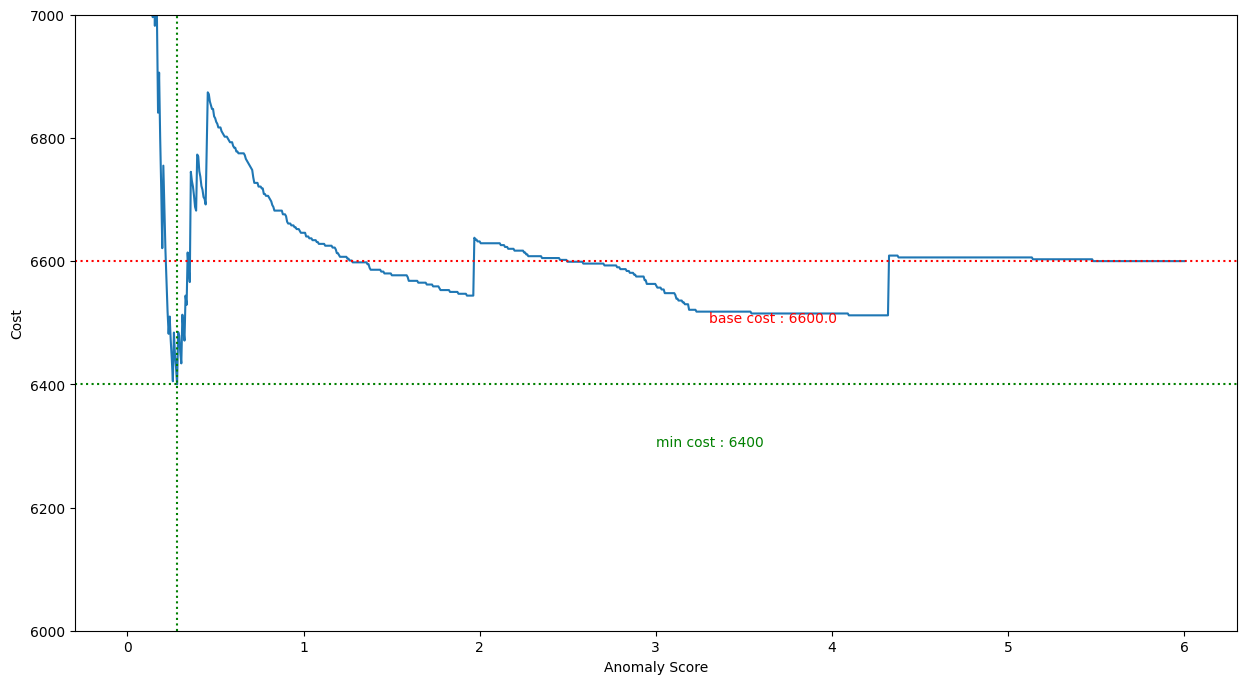

In [ ]:
min_tres = round(thresholds[np.argmin(cost)],5)

print(f'Anomaly Score : {min_tres},  Min Cost : {min(cost)}' )
plt.figure(figsize = (15, 8))
plt.plot(thresholds, cost)

plt.axhline(base_cost, color = 'r', linestyle = ":")
plt.axhline(min(cost), color = 'g', linestyle = ":")
plt.axvline(min_tres, color = 'g', linestyle = ":")

plt.text(max(thresholds)/2+ 0.3, base_cost-100, f"base cost : {base_cost}", color = 'r')
plt.text(max(thresholds)/2, min(cost)-100, f"min cost : {min(cost)}", color = 'g')

plt.ylim(6000, 7000)
plt.xlabel("Anomaly Score")
plt.ylabel("Cost")

plt.show()

* LSTM+AE2

Anomaly Score : 0.16817,  Min Cost : 6395


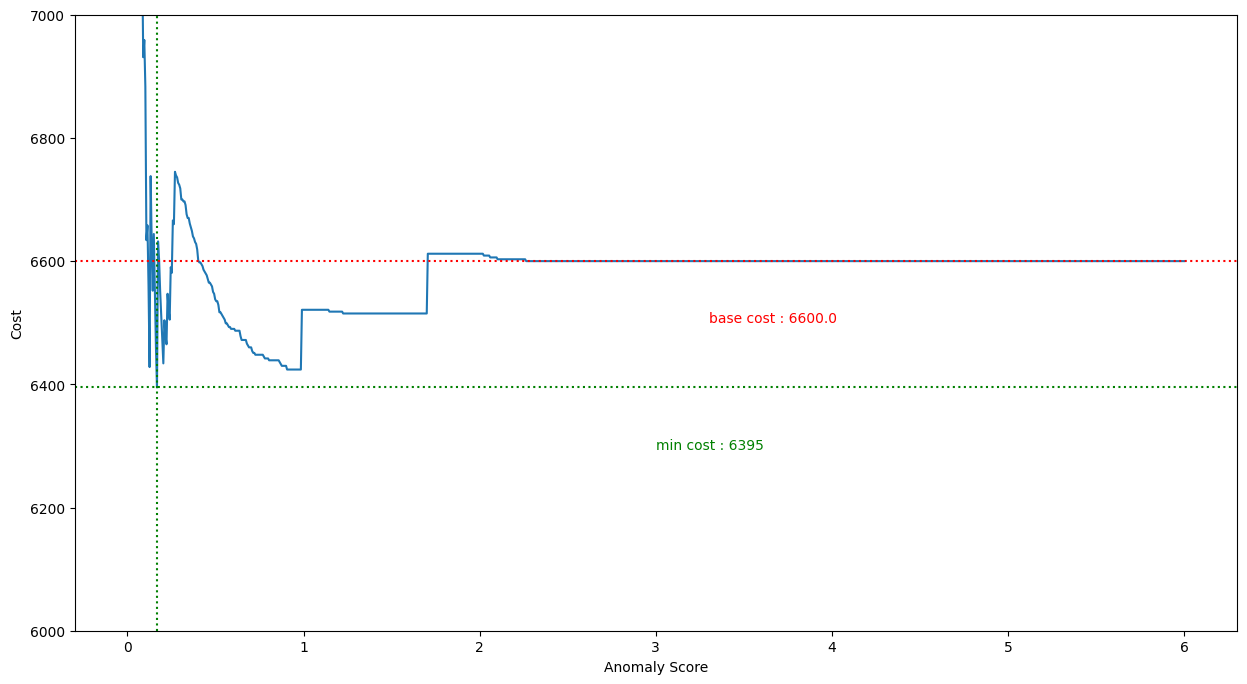

In [ ]:
min_tres2 = round(thresholds[np.argmin(cost2)],5)

print(f'Anomaly Score : {min_tres2},  Min Cost : {min(cost2)}' )
plt.figure(figsize = (15, 8))
plt.plot(thresholds, cost2)

plt.axhline(base_cost, color = 'r', linestyle = ":")
plt.axhline(min(cost2), color = 'g', linestyle = ":")
plt.axvline(min_tres2, color = 'g', linestyle = ":")

plt.text(max(thresholds)/2 + 0.3, base_cost-100, f"base cost : {base_cost}", color = 'r')
plt.text(max(thresholds)/2, min(cost2)-100, f"min cost : {min(cost2)}", color = 'g')

plt.ylim(6000, 7000)
plt.xlabel("Anomaly Score")
plt.ylabel("Cost")

plt.show()